In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm.auto import tqdm
import requests
import json

This notebook documents my setting-up of the auto stage calibration fuctions I wrote for nplab to work with the OpenFlexure Microscope.  The first thing we need to do is set up a connection to the microscope - that's handled by the ``microscope_client`` module (very much a work in progress).  NB we have to do a slightly dirty work-around otherwise we waste loads of time on mdsn requests (we deliberately look up the microscope's IP address and use that, instead of "microscope.local").  I don't know whether that should be blamed on ``requests``, Python, or Windows - but either way, the solution below sorts it out!

In [2]:
import microscope_client
import socket
from importlib import reload
reload(microscope_client)
addr = socket.gethostbyname("microscope.local") # This is a slightly dirty work-around to cache the mDNS lookup needed to resolve .local addresses.  Using microscope.local directly can result in a 3-5 second delay on every request under Windows.
microscope = microscope_client.MicroscopeClient(addr, 5000)

In order to make sure the stage is moving properly, we move it back and forth by a small amount.  If it doesn't return to the starting point, something is wrong!

In [3]:
pos = microscope.position
starting_pos = pos.copy()
print(pos)
pos['x'] += 100
microscope.move(pos)
assert microscope.position == pos
pos['x'] -= 100
microscope.move(pos)
assert microscope.position == starting_pos

{'x': 22111, 'y': -3652, 'z': 7142}


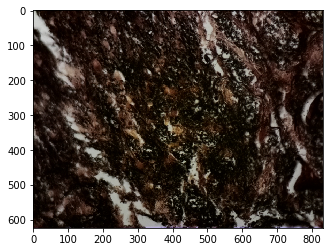

In [4]:
image = microscope.grab_image()
plt.imshow(np.array(image))
#print(image.metadata)

The code that deals with mapping image coordinates to stage coordinates relies on passing around images that include location metadata.  These are ultimately numpy arrays, plus some metadata.  We might think about a more JPEG-friendly way to do this in the future, but I'm going to use these for now!  ``image_with_location`` and ``array_with_attrs`` are copied verbatim from [``nplab``](https://github.com/nanophotonics/nplab).

In [5]:
from image_with_location import ImageWithLocation, ensure_3d, ensure_2d, locate_feature_in_image, datum_pixel

The meat of the camera-to-image calibration is defined in the ``CameraWithLocation`` class.  This has been taken out of nplab and modified to remove nplab dependencies.  I'll continue stripping out unnecessary stuff (like the autofocus function) until it's acceptably lean.

# Auto-calibration
The code below will start by moving the stage to figure out a rough estimate of pixels to steps, and determine approximately how much backlash we have.  For now, it just uses the three-function interface to the camera/stage, to keep it easy to update.  The calibration steps are:

* Determine approximate step size
  * Move the stage in increasing increments, until we see the image move
  * Keep going until we get close to one edge of the field of view
* Determine step size more precisely and measure backlash
  * Move to the other side of the field of view in ~10 steps
  * Reverse direction and return to the first edge of the FoV
  * Fit this motion to a simple 1D model of backlash
* Return to the starting point in several steps, testing out backlash-corrected moves.

After this is complete, we'll have a decent estimate of backlash and step size for one axis.  We can either assume it's the same for X and Y, or measure them independently.

In [6]:
import time
import camera_stage_tracker as cst
reload(cst)

grab_image = microscope.grab_image_array
get_position = microscope.get_position_array
move = microscope.move
def wait():
    time.sleep(0.2)


Moving the stage until we see motion...
Moving the stage to the edge of the field of view...
Moving the stage backwards to measure backlash (1/2)..........
Moving the stage forwards to measure backlash (2/2).........
Moving back to the start, correcting for backlash...
Estimated backlash 126 steps
Stage-to-image ratio 0.211 pixels/step
Residuals were about 0.04 times the step size
Successfully calibrated stage in 28 seconds


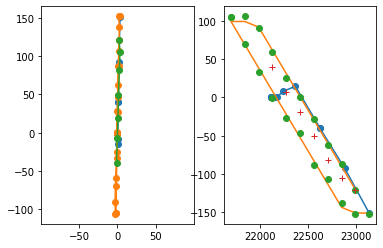

In [7]:
import camera_stage_calibration_1d as c1d
reload(c1d)
direction = np.array([1,0,0]) # We move in this direction

start = time.time()
# Set up image-based position tracking, and acquire a template image
tracker = cst.Tracker(grab_image, get_position, settle=wait)
results_x = c1d.calibrate_backlash_1d(tracker, move, direction)
finish = time.time()
c1d.plot_1d_backlash_calibration(results_x)

print(f"Successfully calibrated stage in {finish - start:.0f} seconds")

Moving the stage until we see motion...
Moving the stage to the edge of the field of view...
Moving the stage backwards to measure backlash (1/2)........
Moving the stage forwards to measure backlash (2/2)........
Moving back to the start, correcting for backlash...
Estimated backlash 40 steps
Stage-to-image ratio 0.217 pixels/step
Residuals were about 0.05 times the step size
Successfully calibrated stage in 37 seconds


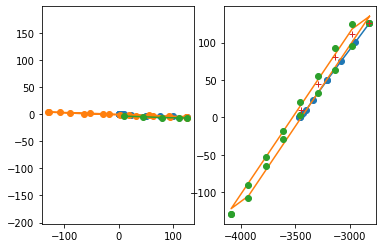

In [19]:
start = time.time()
# Set up image-based position tracking, and acquire a template image
tracker = cst.Tracker(grab_image, get_position, settle=wait)
results_y = c1d.calibrate_backlash_1d(tracker, move, np.array([0,1,0]))
c1d.plot_1d_backlash_calibration(results_y)
finish = time.time()

print(f"Successfully calibrated stage in {finish - start:.0f} seconds")

# 2D Calibration
We've now estimated backlash for one axis (and could do so for the other).  Actually, the two calibrations are already sufficient to fit a half-decent model

In [24]:
import pprint
reload(c1d)
combined_calibration = c1d.image_to_stage_displacement_from_1d([results_x, results_y])
backlash = combined_calibration["backlash"]
pprint.pprint(combined_calibration)

{'backlash': 126.27716717377848,
 'backlash_vector': array([126.27716717,  39.95488493,   0.        ]),
 'image_to_stage_displacement': array([[ 0.15543857,  4.60073409],
       [ 4.28860586, -0.11103582]])}


That's probably at least as good as the old method, but for completeness, here's the grid calibration, refactored out of `nplab`'s `CameraWithLocation` class:

In [25]:
import camera_stage_calibration_2d as c2d
reload(c2d)
move_blash = c2d.bake_backlash_corrected_move(get_position, move, backlash*1.5)
tracker = cst.Tracker(grab_image, get_position, wait)
tracker.acquire_template()
results_grid = c2d.calibrate_xy_grid(tracker, move_blash, step=300)

Ratio of residuals to displacement is 0.46335849732692885)
Calibrated the pixel-location matrix.
Residuals were 46.3% of the shift.


RMS residuals are 0.028959906082933053
RMS residuals are 0.035741229155562874
RMS residuals are 0.030864614705273817
RMS residuals are 0.03147586345568775


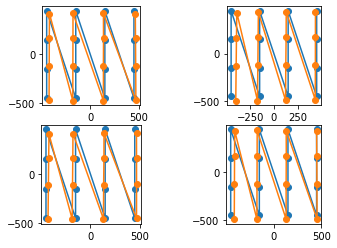

In [27]:
from numpy.linalg import norm

A = results_grid["image_to_stage_displacement"]
B = combined_calibration["image_to_stage_displacement"]

f, ax = plt.subplots(2,2)
for a, matrix in zip(ax.ravel(), [A, B, B.T, A.T]):
    stage_positions, image_positions = results_grid["moves"]
    transformed_image_positions = np.dot(image_positions, matrix)
    a.plot(stage_positions[:,0], stage_positions[:,1], 'o-')
    a.plot(transformed_image_positions[:,0], transformed_image_positions[:,1], 'o-')
    a.set_aspect(1)
        
    residuals = transformed_image_positions - stage_positions
    print(f"RMS residuals are {norm(residuals) / residuals.shape[0] / 300}")

A fairer test would be to take a whole new grid of points, and compare the results on that using the two different matrices.

In [28]:
move(get_position() + [2000,0,0])
move_blash = c2d.bake_backlash_corrected_move(get_position, move, backlash*1.5)
tracker = cst.Tracker(grab_image, get_position, wait)
results_grid2 = c2d.calibrate_xy_grid(tracker, move_blash, step=300)

Ratio of residuals to displacement is 0.4259725420963183)
Calibrated the pixel-location matrix.
Residuals were 42.6% of the shift.


RMS residuals are 0.03500811994050276
RMS residuals are 0.03579184236069258
RMS residuals are 0.03532794242415514
RMS residuals are 0.04108021074420483


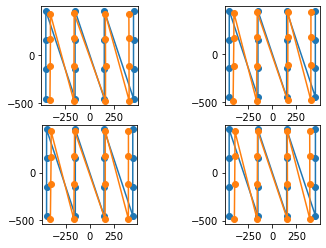

In [29]:
from numpy.linalg import norm
A = results_grid["image_to_stage_displacement"]
B = image_to_stage_displacement_from_1d
stage_positions, image_positions = results_grid2["moves"]

f, ax = plt.subplots(2,2)
for a, matrix in zip(ax.ravel(), [A, B, B.T, A.T]):
    transformed_image_positions = np.dot(image_positions, matrix)
    a.plot(stage_positions[:,0], stage_positions[:,1], 'o-')
    a.plot(transformed_image_positions[:,0], transformed_image_positions[:,1], 'o-')
    a.set_aspect(1)
        
    residuals = transformed_image_positions - stage_positions
    print(f"RMS residuals are {norm(residuals) / residuals.shape[0] / 300}")

I think I like the calibration of each axis separately, as it lets us be rather more rigorous in how we fit the motion - which is probably good for repeatability in the long run.  It's also nicely handling automatic step size selection and backlash calibration, neither of which I ever really managed with the grid calibration method.

# Working camerawithlocation
Let's plug this all in to the camerawithlocation class, with calibration removed.

In [ ]:
def ensure_grayscale(image):
    """Given an image that may be 2D (monochrome) or 3D (colour), return a monochrome version"""
    if len(image.shape) == 3:
        return np.mean(image, axis=2).astype(image.dtype)
    else:
        return image
    
def ensure_color(image):
    """Ensure an image is 3-dimensional, promoting 2D images to NxMx3"""
    if len(image.shape) == 2:
        return np.stack([image]*3, axis=2)
    else:
        return image

class CameraWithLocation(object):
    """
    A class wrapping a camera and a stage, allowing them to work together.

    This is designed to handle the low-level stuff like calibration, crosscorrelation, and closed-loop stage control.
    It also handles autofocus, and has logic for drift correction.  It could compensate for a non-horizontal sample to
    some extent by adding a tilt to the image plane - but this is as yet unimplemented.
    """
    pixel_to_sample_displacement = None # A 3x3 matrix that relates displacements in pixels to distance units
    pixel_to_sample_displacement_shape = None # The shape of the images taken to calibrate the stage
    drift_estimate = None # Reserved for future use, to compensate for drift
    datum_pixel = None # The position, in pixels in the image, of the "datum point" of the system.
    settling_time = 0.0 # How long to wait for the stage to stop vibrating.
    frames_to_discard = 1 # How many frames to discard from the camera after a move.
    backlash_estimate = None # Future use: keep track of backlash
    backlash_compensation_amount = None # This should be either a 3-element array or None

    def __init__(self, get_position_fn, move_fn, grab_image_fn):
        """This class adds location functionality to a camera.
        
        It's taken from nplab, and is particularly appropriate for microscopes.
        
        get_position_fn must be a function that returns the stage's position as an iterable
        of (usually) 3 numbers
        move accepts a 3-element array and does an absolute move to that position
        grab_image_fn returns an image as a (2 or 3, mostly tested with 3) dimensional array
        """
        self._get_position_function = get_position_fn
        self._move_function = move_fn
        self._grab_image_function = grab_image_fn

        shape = self._grab_image_function().shape
        self.datum_pixel = np.array(shape[:2])/2.0 # Default to using the centre of the image as the datum point

    def log(self, message):
        """This is a standard nplab thing - work around with print statements!"""
        print("[log]: "+message)
        
    @property
    def pixel_to_sample_matrix(self):
        here = self.datum_location
        assert self.pixel_to_sample_displacement is not None, "The CameraWithLocation must be calibrated before use!"
        datum_displacement = np.dot(ensure_3d(self.datum_pixel), self.pixel_to_sample_displacement)
        M = np.zeros((4,4)) # NB M is never a matrix; that would create issues, as then all the vectors must be matrices
        M[0:3, 0:3] = self.pixel_to_sample_displacement # We calibrate the conversion of displacements and store it
        M[3, 0:3] = here - datum_displacement # Ensure that the datum pixel transforms to here.
        return M

    def _add_position_metadata(self, image):
        """Add position metadata to an image, assuming it has just been acquired"""
        iwl = ImageWithLocation(image)
        iwl.attrs['datum_pixel'] = self.datum_pixel
        iwl.attrs['stage_position'] = self.get_stage_position()
        if self.pixel_to_sample_displacement is not None:
            #TODO: make sure we check the size of the image matches
            iwl.attrs['pixel_to_sample_matrix'] = self.pixel_to_sample_matrix
        else:
            iwl.attrs['pixel_to_sample_matrix'] = np.identity(4)
            print('Stage is not yet calibrated')
        return iwl


    ####### Wrapping functions for the camera #######
    def grab_image(self, *args, **kwargs):
        """Return an image from the camera, including position metadata"""
        return self._add_position_metadata(self._grab_image_function(*args, **kwargs))
    
    def grab_image_unannotated(self, *args, **kwargs):
        """Return an image, without adding metadata"""
        return self._grab_image_function(*args, **kwargs)

    def thumb_image(self,size = (100,100)):
        """Return a cropped "thumb" from the centre of the CWL with given size"""
        # TODO: should this use datum_pixel?
        # TODO: should this be part of imagewithlocation?
        image = self.grab_image()
        thumb = image[(image.shape[0]-size[0])//2:(image.shape[0]+size[0])//2,
                      (image.shape[1]-size[1])//2:(image.shape[1]+size[1])//2,
                      ...]
        return thumb

    ###### Wrapping functions for the stage ######
    def move_stage(self, *args, **kwargs): # TODO: take account of drift
        """Move the stage to a given position"""
        self._move_function(*args, **kwargs)
        
    def get_stage_position(self):
        """Return the stage's position as a numpy array"""
        return np.array(self._get_position_function())

    def move_stage_rel(self, pos, *args, **kwargs):
        """Move the stage by a given amount"""
        current_pos = self.get_stage_position()
        
        
    def move_to_pixel(self,x,y):
        """Move to a given pixel, in a new image obtained from the camera."""
        iwl = ImageWithLocation(self.grab_image())
        iwl.attrs['datum_pixel'] = self.datum_pixel
#        self.use_previous_datum_location = True
        iwl.attrs['pixel_to_sample_matrix'] = self.pixel_to_sample_matrix
        if (iwl.pixel_to_sample_matrix != np.identity(4)).any():
            #check if the image has been calibrated
            #print('move coords', image.pixel_to_location([x,y]))
            #print('current position', self.stage.position)
            self.move_stage(iwl.pixel_to_location([x,y]))
            #print('post move position', self.stage.position)
#        self.use_previous_datum_location = False
    @property
    def datum_location(self):
        """The location in the sample of the datum point (i.e. the current stage position, corrected for drift)"""
        if self.drift_estimate == None:
            return self.get_stage_position()
        else:
            return self.get_stage_position()-self.drift_estimate
        return self.get_stage_position() - self.drift_estimate

    ####### Useful functions for closed-loop stage control #######
    def settle(self):
        """Wait for the stage to stop moving/vibrating, and (unless specified) discard frame(s) from the camera.

        After moving the stage, to get a fresh image from the camera we usually need to both wait for the stage to stop
        vibrating, and discard one or more frames from the camera, so we have a fresh one.  This function does both of
        those things (except if flush_camera is False).
        """
        time.sleep(self.settling_time)
        for i in range(self.frames_to_discard):
            self.grab_image_unannotated()

    def move_to_feature(self, feature, ignore_position=False, ignore_z_pos = False, margin=50, tolerance=0.5, max_iterations = 10, return_moves=False, correct_for_backlash=True):
        """Bring the feature in the supplied image to the centre of the camera

        Strictly, what this aims to do is move the sample such that the datum pixel of the "feature" image is on the
        datum pixel of the camera.  It does this by first (unless instructed not to) moving to the datum point as
        defined by the image.  It then compares the image from the camera with the feature, and adjusts the position.

        feature : ImageWithLocation or numpy.ndarray
            The feature that we want to move to.
        ignore_position : bool (optional, default False)
            Set this to true to skip the initial move using the image's metadata.
        margin : int (optional)
            The maximum error, in pixels, that we can cope with (this sets the size of the search area we use to look
            for the feature in the camera image, it is (2*range + 1) in both X and Y.  Set to 0 to use the maximum
            possible search area (given by the difference in size between the feature image and the camera image)
        tolerance : float (optional)
            Once the error between our current position and the feature's position is below this threshold, we stop.
        max_iterations : int (optional)
            The maximum number of moves we make to fine-tune the position.
        """
        if (feature.datum_pixel[0]<0 or feature.datum_pixel[0]>np.shape(feature)[0] or 
            feature.datum_pixel[1]<0 or feature.datum_pixel[1]>np.shape(feature)[1]):
                self.log('The datum picture of the feature is outside of the image!',level = 'WARN')
            
        starting_position = self.get_stage_position()
        stage_positions = [starting_position]
        image_positions = []
        print(f"starting at {starting_position}.")
        
        if not ignore_position:
            try:
                initial_move = feature.datum_location
                print(f"the feature should be at {initial_move}")
                if ignore_z_pos==True:
                    print("Truncating initial move to avoid Z")
                    initial_move = initial_move[:2]
                if correct_for_backlash and self.backlash_compensation_amount is not None:
                    # We deliberately under/overshoot on the initial move to avoid 
                    # backlash when we're fine tuning X and Y
                    initial_move[:2] -= 1.5*self.backlash_compensation_amount[:2]
                    print(f"we will move instead to {initial_move}")
                self.move_stage(initial_move) #initial move to where we recorded the feature was
                if correct_for_backlash and self.backlash_compensation_amount is not None:
                    # If we've adjusted for backlash, wind forwards again.  This should leave us
                    # with a small adjustment to make, which ought to be in the forwards direction.
                    stage_positions.append(self.get_stage_position())
                    initial_move[:2] += self.backlash_compensation_amount[:2]
                    print(f"adjusting back to {initial_move}")
                    self.move_stage(initial_move)
            except:
                print("Warning: no position data in feature image, skipping initial move.")
                
        last_move = np.infty
        for i in range(max_iterations):
            try:
                self.settle()
                image = self.grab_image()
                pixel_position = locate_feature_in_image(image, feature, margin=margin, restrict=margin>0)
                stage_positions.append(self.get_stage_position())
                image_positions.append(pixel_position)
                new_position = image.pixel_to_location(pixel_position)
                self.move_stage(new_position)
                last_move = np.sqrt(np.sum((new_position - image.datum_location)**2)) # calculate the distance moved
                self.log(f"Centering on feature, iteration {i}, moved by {last_move}")
                if last_move < tolerance:
                    break
            except Exception as e:
                self.log("Error centering on feature, iteration {} raised an exception:\n{}\n".format(i, e) +
                         "The feature size was {}\n".format(feature.shape) +
                         "The image size was {}\n".format(image.shape))
        stage_positions.append(self.get_stage_position())
        if last_move > tolerance:
            self.log("Error centering on feature, final move was too large.")
        if return_moves:
            return last_move < tolerance, np.array(stage_positions), np.array(image_positions)
        else:
            return last_move < tolerance
        
    def move_to_feature_pixel(self,x,y,image = None, **kwargs):
        if self.pixel_to_sample_matrix is not None:
            if image is None:
                image = self.grab_image()
            feature = image.feature_at((x,y))
            self.last_feature = feature
            return self.move_to_feature(feature, **kwargs)
        else:
            print('CameraWithLocation is not yet calibrated!!')
            
    def determine_step_size(self, *args):
        raise NotImplemented
    
    def calibrate_backlash(self, *args):
        raise NotImplemented
        
    def calibrate_xy(self,update_progress=lambda p:p, step = 100, n_steps=4, backlash_compensation=0):
        """Make a series of moves in X and Y to determine the XY components of the pixel-to-sample matrix.

        Arguments:
        step : float, optional (default None)
            The amount to move the stage by.  This should move the sample by approximately 1/10th of the field of view.
            If it is left as None, we will attempt to auto-determine the step size (see below).
        min_step : float, optional
            If we auto-determine the step size, start with this step size.  It's deliberately tiny.
        max_step : float, optional
            If we're auto-determining the step size, fail if it looks like it's more than this.

        This starts by gingerly moving the stage a tiny amount.  That is repeated, increasing the distance exponentially
        until we see a reasonable movement.  This means we shouldn't need to worry too much about setting the distance
        we use for calibration.

        NB this currently assumes the stage deals with backlash correction for us.
        """
        tracker = Tracker(self.grab_image_unannotated, self.get_stage_position, settle=self.settle)
        tracker.acquire_template()
        tracker.reset_history() # make sure we get rid of the initial (0,0) point
        
        # Deal with backlash compensation
        if backlash_compensation > 0:
            move = partial(backlash_corrected_move, self.get_stage_position, self.move_stage, backlash_compensation)
        else:
            move = self.move_stage
        
        starting_position = self.get_stage_position()
        # Move the stage in a square, recording the displacement from both the stage and the camera
        try:
            for x in (np.arange(n_steps) - n_steps/2.0)*step:
                for y in (np.arange(n_steps) - n_steps/2.0)*step:
                    move(starting_position + np.array([x, y, 0]))
                    tracker.append_point()
        finally:
            move(starting_position)
        # We then use least-squares to fit the XY part of the matrix relating pixels to distance
        # stage_positions should be the stage positions, with a zero mean.
        # image_positions also has zero mean for x and y, but is calculated from cross-correlation.
        stage_positions, image_positions = tracker.history
        stage_positions = stage_positions.astype(np.float)
        stage_positions -= np.mean(stage_positions, axis=0)
        stage_positions = stage_positions[:,:2] # ensure it's 2d
        image_positions -= np.mean(image_positions, axis=0)
        image_positions *= -1 # To get the matrix right, we want the position of each
                            # image relative to the template, rather than the other way around
        print(f"The image, stage position arrays are {image_positions.shape},{stage_positions.shape}")
        A, res, rank, s = np.linalg.lstsq(image_positions, stage_positions) # we solve pixel_shifts*A = location_shifts

        self.pixel_to_sample_displacement = np.zeros((3,3))
        self.pixel_to_sample_displacement[2,2] = 1 # just pass Z through unaltered
        self.pixel_to_sample_displacement[:2,:2] = A # A deals with xy only
        transformed_image_positions = np.dot(image_positions, A)
        residuals = transformed_image_positions - stage_positions
        fractional_error = np.sum(residuals**2)**0.5 / np.sum(stage_positions.astype(float)**2)**0.5
        print(f"Ratio of residuals to RMS displacement is {fractional_error})")
        if fractional_error > 0.05: # Check it was a reasonably good fit
            print("Warning: the error fitting measured displacements was %.1f%%" % (fractional_error*100))
        print(f"Calibrated the pixel-location matrix.\nResiduals were {fractional_error*100:.1f}% of the shift."
              f"\nStage positions:\n{stage_positions}\nPixel shifts:\n{image_positions}\n"
              f"Resulting matrix:\n{self.pixel_to_sample_displacement}")
        #update_progress(7)
        #self.update_config('pixel_to_sample_displacement',self.pixel_to_sample_displacement)
        return self.pixel_to_sample_displacement, stage_positions, image_positions, fractional_error



In [ ]:
cwl = CameraWithLocation(get_position, move, grab_image)

In [ ]:
matrix, stage_positions, image_positions, fractional_error = cwl.calibrate_xy(step=300, backlash_compensation=256)

In [ ]:
cwl = CameraWithLocation(get_position, move, grab_image)
cwl.pixel_to_sample_displacement = matrix

In [ ]:
#A, res, rank, s = np.linalg.lstsq(image_positions, stage_positions)
transformed_image_positions = np.dot(image_positions, matrix[:2,:2])
f, ax = plt.subplots(1,2)
ax[0].plot(stage_positions[:,0], stage_positions[:,1], 'o-')
ax[0].plot(transformed_image_positions[:,0], transformed_image_positions[:,1], 'o-')
for a in ax:
    a.set_aspect(1)
    
residuals = transformed_image_positions - stage_positions
print(f"RMS residuals are {np.sum(residuals**2)**0.5 / np.sum(stage_positions.astype(float)**2)**0.5}")

In [ ]:
success, stage_positions, image_positions = cwl.move_to_feature_pixel(340,320,tolerance=20, return_moves=True)
f, ax = plt.subplots(1,2)
ax[0].plot(stage_positions[:,0], stage_positions[:,1], 'o-')
ax[1].plot(image_positions[:,0], image_positions[:,1], 'o-')
for a in ax:
    a.set_aspect(1, adjustable="datalim")

In [ ]:
cwl.backlash_compensation_amount = np.array([256]*3)

In [ ]:
success, stage_positions, image_positions = cwl.move_to_feature_pixel(140,320,tolerance=50, return_moves=True)
f, ax = plt.subplots(1,1)
stage_positions = np.array(stage_positions)
ax.plot(stage_positions[:,0], stage_positions[:,1], 'o-')
ax.plot(stage_positions[1,0], stage_positions[1,1], '+')
ax.set_aspect(1, adjustable="datalim")

In [ ]:
success, stage_positions, image_positions = cwl.move_to_feature_pixel(140,320,tolerance=20, return_moves=True)
f, ax = plt.subplots(1,1)
ax.plot(stage_positions[:,0], stage_positions[:,1], 'o-')
ax.set_aspect(1, adjustable="datalim")

In [ ]:
success, stage_positions, image_positions = cwl.move_to_feature_pixel(140,320,tolerance=20, return_moves=True)
f, ax = plt.subplots(1,1)
expected_location = stage_positions[1,:2] + 1.5*cwl.backlash_compensation_amount[:2]
ax.plot(stage_positions[:,0], stage_positions[:,1], 'o-')
ax.plot(expected_location[0], expected_location[1], '+')
ax.set_aspect(1, adjustable="datalim")

In [37]:
from collections import OrderedDict
t = OrderedDict(a=1, b=2)
print(t)
print(dict(t))
a, b = dict(t)
print(a,b)

OrderedDict([('a', 1), ('b', 2)])
{'a': 1, 'b': 2}
a b
